<a href="https://colab.research.google.com/github/SarthV/Machine-Learning-with-Python/blob/master/Sentiment_Analysis_MNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install wordcloud

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pandas.util.testing as tm
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/labeledTrainData.tsv", delimiter="\t")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/testData.tsv", delimiter="\t")

In [39]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


(array([12500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

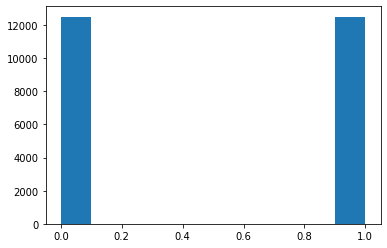

In [15]:
plt.hist(train['sentiment'])
## have a look at the distribution of sentiments.

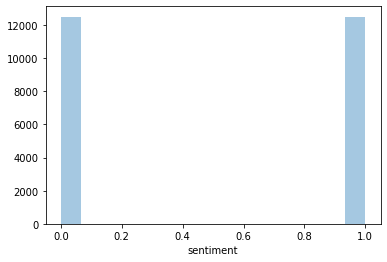

In [16]:
sns.distplot(train['sentiment'], axlabel="sentiment", kde= False)

In [0]:
text = "".join(review for review in train.review)
## joining every review to create a text

In [0]:
class Tokenizer:
  def cleandata(self, text):
    no_html = BeautifulSoup(text).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags = re.IGNORECASE)
    str = re.sub("(\s+)", " ", clean)
    return str;

  def tokenization(self, text):
    clean = self.cleandata(text).lower()
    en_stopwords = stopwords.words("english")
    return [w for w in re.split("\W+", clean)
      if not w in en_stopwords]
## Here en_stopword refer to the common words in English like "the", "and", "is" etc. which can be ommitted mfrom further analysis.
## "\W+" refers to all the non alphanumeric symbols in the 'clean' string and thus is the place where the 'clean' string is to be split.
## re.split() returns all those split strings. Thus, a list is obtained of the splitted strings without the stopwords.
## Tokenizer creates a "bag of words model" for us to work with.

In [0]:
class MultinomialNB:
  def __init__(self, classes, tokenizer):
    self.classes = classes
    self.tokenizer = tokenizer
  
  def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
## data is a dictionary conatining reviews mapped to their respective classes.
## i.e. it has the mapping of the reviews and their sentiments

  def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        ## grouped_data is thus a dictionary which has a mapping of the reviews and their sentiments

        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
        ## n_class_items keep track of the number of reviews of the particular sentiments in the training set.
        ## log_class_priors keeps the track of the logarithm of the prior probability of the respective classes.
        ## word_counts keep the track of the total number of unique words in the reviews of a particular sentiment. 

          for text in data:
            counts = Counter(self.tokenizer.tokenization(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
        ## text is any of the reviews of a particular class/ sentiment.
        ## tokenization function is called to first clean the review (see cleandata function) and then the stopwords are removed 
        ## and a list of all the words in the review is returned.
        ## a dictionary called as vocab is maintained to store all the unique words in the training set.
        ## Along with this word_counts a dictionary with the mapping of words in a particular class and their number of occurences in it is also updated.
      
  def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      ## First see the predict function below which will direct you to come here.
      ## Here laplace smoothing is used only because it is highly possible that a  word is present in only one of the sentiment classes, 
      ## which would then lead to a situation of log(0)! in calulation of the probabilities. To understand more about
      ## this, see the READ.me file. Thus, laplace smoothing simple adds 1 to the numerator to avoid such a situation.

  def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenization(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)  ## read about this function to kow more!
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

        ## the predict function as its name, predicts the sentiment of a review presented to it using the multinomial naive bayes probability theorem.
        ## text is here any review in the test set. For every word in the text, it is first checked if it is present in our vocab. If not, then we simply skip this word.
        ## Then we calculate the respective posterior probabilities using laplace smoothing. These are then added to the respective class score so as to get the 
        ## posterior probabilities of the respective classses. The class with the maximum score is picked as the answer and appended to the result list of the predictions.


In [0]:
X = train['review'].values
y = train['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
MNB = MultinomialNB(
    classes=np.unique(y), 
    tokenizer=Tokenizer()).fit(X_train, y_train)
## Setting up the MNB model.

In [49]:
y_hat = MNB.predict(X_test)
accuracy_score(y_test, y_hat)

0.8584

In [50]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix
## Getting the confusion matrix. We have also plotted below thie same using sns heatplot.
## for ideas on plotting confusion matrix, follow this link " https://github.com/wcipriano/pretty-print-confusion-matrix " .

array([[2030,  470],
       [ 238, 2262]])

In [0]:
df = pd.DataFrame(cnf_matrix, [0,1], [0,1])

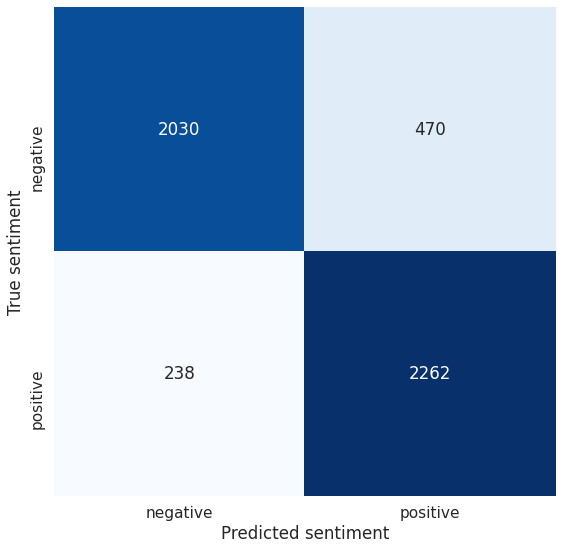

In [99]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
fig = plt.figure(figsize= (9,9))
sns.heatmap(df, annot=True, fmt="", cmap='Blues', xticklabels= ["negative", "positive"], yticklabels= ["negative", "positive"], cbar=False)
plt.xlabel("Predicted sentiment")
plt.ylabel("True sentiment")
plt.show()